In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

import keras
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, BatchNormalization, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, Conv2DTranspose, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import datetime

from keras import initializers


Using TensorFlow backend.


In [2]:
pip install gdown

In [3]:
import gdown 
gdown.download("https://drive.google.com/uc?id={0}".format("1-JVnG_wVJR3VgAwi6-Hhu2C-ZAyQ2-_9"),"gt.pickle",quiet = False)
gdown.download("https://drive.google.com/uc?id={0}".format("1-7E0x-UGFjotUH8UJAWruM9Y0rwEzYzV"),"occ.pickle",quiet = False)

Downloading...
From: https://drive.google.com/uc?id=1-JVnG_wVJR3VgAwi6-Hhu2C-ZAyQ2-_9
To: /content/gt.pickle
179MB [00:02, 64.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-7E0x-UGFjotUH8UJAWruM9Y0rwEzYzV
To: /content/occ.pickle
179MB [00:02, 77.1MB/s]


'occ.pickle'

In [4]:
!ls

Graph  gt.pickle  occ.pickle  sample_data


In [0]:
pickle_in = open("occ.pickle","rb")
x = pickle.load(pickle_in)

pickle_in = open("gt.pickle","rb")
y = pickle.load(pickle_in)

In [0]:
from skimage.transform import resize

x = resize(x, (len(x),64,64,1),anti_aliasing=False)
y= resize(y, (len(y),64,64,1),anti_aliasing=False)

In [7]:
print(x.shape)
print(y.shape)

(4471, 64, 64, 1)
(4471, 64, 64, 1)


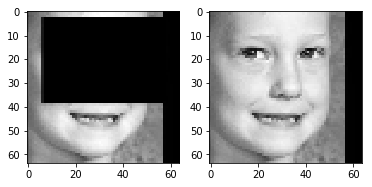

In [8]:



fig = plt.figure(figsize = (6,6))
fig.add_subplot(1,2,1)
plt.imshow(x[0,:,:,0], cmap = "gray")
fig.add_subplot(1,2,2)
plt.imshow(y[0,:,:,0], cmap = "gray")

In [9]:
def creategen():
  generator = Sequential()
  
  generator.add(Conv2D(64,(5,5),strides = (2,2), input_shape = x.shape[1:], padding = "SAME", kernel_initializer = "random_normal" ))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  generator.add(Dropout(0.3))
  
  generator.add(Conv2D(128,(5,5),strides = (2,2), padding = "SAME", kernel_initializer = "random_normal" ))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  generator.add(Dropout(0.3))
  
  generator.add(Conv2D(256,(5,5),strides = (2,2), padding = "SAME", kernel_initializer = "random_normal" ))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  generator.add(Dropout(0.3))
  
  
  
  generator.add(Conv2DTranspose(128,(5,5),strides = (2,2), padding = "SAME", kernel_initializer = "random_normal", use_bias=False ))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  #generator.add(Dropout(0.3))
  
  generator.add(Conv2DTranspose(64,(5,5),strides = (2,2), padding = "SAME", kernel_initializer = "random_normal", use_bias=False ))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  #generator.add(Dropout(0.3))
  
  
  generator.add(Conv2DTranspose(1,(5,5),strides = (2,2), padding = "SAME", kernel_initializer = "random_normal", use_bias=False, activation = "sigmoid" ))
  
  return generator



generator = creategen()

W0706 14:06:46.365491 139832091408256 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
def create_disc():
  discriminator = Sequential()
  
  discriminator.add(Conv2D(64,(5,5),strides = (2,2), input_shape = x.shape[1:], padding = "SAME", kernel_initializer = "random_normal" ))
  discriminator.add(BatchNormalization())
  discriminator.add(ReLU())
  discriminator.add(Dropout(0.3))
  
  discriminator.add(Conv2D(128,(5,5),strides = (2,2), padding = "SAME", kernel_initializer = "random_normal" ))
  discriminator.add(BatchNormalization())
  discriminator.add(ReLU())
  discriminator.add(Dropout(0.3))
  
  discriminator.add(Conv2D(256,(5,5),strides = (2,2), padding = "SAME", kernel_initializer = "random_normal" ))
  discriminator.add(BatchNormalization())
  discriminator.add(ReLU())
  discriminator.add(Dropout(0.3))
  
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation = "sigmoid"))
  
  return discriminator


discriminator = create_disc()

W0706 14:06:47.312124 139832091408256 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [12]:
opt_disc = Adam(lr=0.00004)
discriminator.trainable = True
discriminator.compile(loss = "binary_crossentropy", optimizer = opt_disc)
discriminator.summary()

W0706 14:06:47.387910 139832091408256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 16, 16, 128)      

In [13]:
opt_gen = Adam(lr=0.00001)
generator.compile(loss = "mean_squared_error", optimizer = opt_disc)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [0]:
def creategan(generator,discriminator):
  gan = Sequential()
  gan.add(generator)
  
  discriminator.trainable = False
  gan.add(discriminator)
  
  return gan

gan = creategan(generator,discriminator)


In [15]:
opt_gan = Adam(lr=0.00001)
gan.compile(loss = "binary_crossentropy", optimizer = opt_gan)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         2054208   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1044225   
Total params: 3,098,433
Trainable params: 2,052,928
Non-trainable params: 1,045,505
_________________________________________________________________


In [0]:
def train (x, y, nepoch):
    
  gen_predict = None
  
  gan_inp = x
  gan_label = np.ones(64)
  gan_predict = None
  
  
  disc_inp = None
  disc_label = np.zeros(64*2)
  disc_label[64:] = 1
  
  disc_predict = None
  
  #sess = tf.Session()
  
  for epoch in range(nepoch):
    for batch_ctr in range(64):
      
      gen_predict = generator.predict(gan_inp[batch_ctr*64:(batch_ctr+1)*64])
      
      if(epoch%2==0):
        
        disc_inp = gen_predict
        disc_label = np.zeros(64)
        
      else:
        disc_inp = y[batch_ctr*64:(batch_ctr+1)*64]
        disc_label = np.ones(64)
        
        
      gen_label = y[batch_ctr*64:(batch_ctr+1)*64]
      
      d_loss = discriminator.train_on_batch(disc_inp,disc_label)
      
      
      gan_loss = gan.train_on_batch(gan_inp[batch_ctr*64:(batch_ctr+1)*64],
                                   gan_label)
      
      gen_loss = generator.train_on_batch(gan_inp[batch_ctr*64:(batch_ctr+1)*64],gen_label)
  
    print("Epoch {0} Gan Loss {1} Disc Loss {2} Gen Loss {3}".format(epoch,gan_loss,d_loss,gen_loss))
    

In [17]:
batch_size = 64
train(x,y,50)

W0706 14:06:49.810908 139832091408256 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Epoch 0 Gan Loss 4.538021087646484 Disc Loss 0.0009165122755803168 Gen Loss 0.035139862447977066
Epoch 1 Gan Loss 0.0003221739025320858 Disc Loss 0.0003237011260353029 Gen Loss 0.024659734219312668
Epoch 2 Gan Loss 0.5286794900894165 Disc Loss 0.004998859949409962 Gen Loss 0.020979907363653183
Epoch 3 Gan Loss 0.006017576903104782 Disc Loss 0.004580765962600708 Gen Loss 0.01908819191157818
Epoch 4 Gan Loss 3.5373661518096924 Disc Loss 0.003954537212848663 Gen Loss 0.018040288239717484
Epoch 5 Gan Loss 0.00787793006747961 Disc Loss 0.0021025650203227997 Gen Loss 0.01632670685648918
Epoch 6 Gan Loss 10.995098114013672 Disc Loss 7.832732808310539e-05 Gen Loss 0.01605452410876751
Epoch 7 Gan Loss 0.013163055293262005 Disc Loss 0.0013157154899090528 Gen Loss 0.0152280293405056
Epoch 8 Gan Loss 10.096426010131836 Disc Loss 0.00029045241535641253 Gen Loss 0.014956088736653328
Epoch 9 Gan Loss 0.11243803799152374 Disc Loss 0.0021552154794335365 Gen Loss 0.014266368001699448
Epoch 10 Gan Loss 8

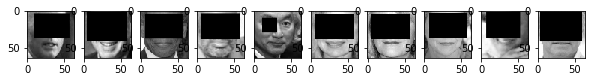

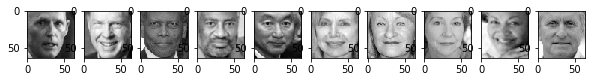

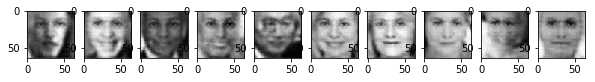

In [21]:
a = 4170
b = 4180

pred = generator.predict(x[a:b])

fig = plt.figure(figsize = (10,10))

for ctr in range(10):
  fig.add_subplot(1,10,ctr+1)
  plt.imshow(np.reshape(x[a+ctr], (64,64)), cmap = "gray")
  
fig = plt.figure(figsize = (10,10))  
for ctr in range(10):
  fig.add_subplot(1,10, ctr+1)
  plt.imshow(np.reshape(y[a+ctr], (64,64)),cmap = "gray")
  
fig = plt.figure(figsize = (10,10))  
for ctr in range(10):
  fig.add_subplot(1,10, ctr+1)
  plt.imshow(np.reshape(pred[ctr], (64,64)), cmap = "gray")
  